In [ ]:
import os
import cv2
import random
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import Counter


# ================= CONFIG =================
VAL_IMAGE_DIR = r"D:\test\fashion_yolo\images\val"
VAL_LABEL_DIR = r"D:\test\fashion_yolo\labels\val"
WEIGHTS_PATH  = r"D:\test\demo\weights\best_yolo.pt"
LABEL_DIR = r"D:\test\fashion_yolo\labels\train"  
TOP_K = 10

NUM_SHOW = 6                     # hiển thị đúng 6 ảnh
CONF_THRES = 0.4
TARGET_CLASSES = ["watch", "belt", "headband, head covering, hair accessory"]
# =========================================

device = "cuda" if torch.cuda.is_available() else "cpu"


# ================= LOAD MODEL =================
model = YOLO(WEIGHTS_PATH)
model.to(device)

class_names = model.names

# Class Count

In [ ]:
# Counter cho số instance mỗi class
class_counter = Counter()

# Duyệt toàn bộ label
for label_file in os.listdir(LABEL_DIR):
    if not label_file.endswith(".txt"):
        continue

    label_path = os.path.join(LABEL_DIR, label_file)

    with open(label_path, "r") as f:
        for line in f:
            cls_id = int(line.strip().split()[0])
            class_counter[cls_id] += 1

# Chuyển sang list + sort tăng dần
sorted_classes = sorted(
    class_counter.items(),
    key=lambda x: x[1]
)

# ===== PRINT TOP K ÍT NHẤT =====
print(f"\nTop {TOP_K} classes có số instance ít nhất:\n")
print(f"{'Rank':<5}{'Class':<20}{'Count'}")
print("-" * 35)

for i, (cls_id, count) in enumerate(sorted_classes[:TOP_K], 1):
    print(f"{i:<5}{class_names[cls_id]:<20}{count}")



Top 10 classes có số instance ít nhất:

Rank Class               Count
-----------------------------------
1    leg warmer          112
2    umbrella            135
3    cape                152
4    ribbon              274
5    tassel              335
6    bow                 528
7    fringe              588
8    vest                719
9    epaulette           874
10   jumpsuit            922


In [ ]:
# Chuyển sang list + sort GIẢM DẦN
sorted_classes = sorted(
    class_counter.items(),
    key=lambda x: x[1],
    reverse=True    
)

# ===== PRINT TOP K NHIỀU NHẤT =====
print(f"\nTop {TOP_K} classes có số instance nhiều nhất:\n")
print(f"{'Rank':<5}{'Class':<20}{'Count'}")
print("-" * 35)

for i, (cls_id, count) in enumerate(sorted_classes[:TOP_K], 1):
    print(f"{i:<5}{class_names[cls_id]:<20}{count}")



Top 10 classes có số instance nhiều nhất:

Rank Class               Count
-----------------------------------
1    sleeve              59448
2    shoe                46374
3    neckline            34258
4    pocket              27179
5    dress               18739
6    top, t-shirt, sweatshirt16548
7    pants               12414
8    collar              10159
9    zipper              7991
10   jacket              7833


# Get GT and Pred target class

In [ ]:
target_class_ids = [i for i, n in class_names.items() if n in TARGET_CLASSES]

print("Target class IDs:", target_class_ids)

# ================= UTILS =================
def yolo_to_xyxy(label, img_w, img_h):
    """Convert YOLO normalized label -> pixel xyxy"""
    cls, xc, yc, w, h = label
    x1 = int((xc - w / 2) * img_w)
    y1 = int((yc - h / 2) * img_h)
    x2 = int((xc + w / 2) * img_w)
    y2 = int((yc + h / 2) * img_h)
    return x1, y1, x2, y2, int(cls)

def draw_boxes(img, boxes, color, label_names=None):
    for box in boxes:
        x1, y1, x2, y2, cls = box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
        if label_names is not None:
            name = label_names[cls]
            cv2.putText(
                img, name, (x1, y1 - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2
            )

def scale_xyxy(box, sx, sy):
    x1, y1, x2, y2, cls = box
    return (
        int(x1 * sx),
        int(y1 * sy),
        int(x2 * sx),
        int(y2 * sy),
        cls
    )


Target class IDs: [15, 18, 19]


In [34]:
# ================= COLLECT VALID SAMPLES =================
image_files = os.listdir(VAL_IMAGE_DIR)
random.shuffle(image_files)

selected = []

for img_name in image_files:
    img_path = os.path.join(VAL_IMAGE_DIR, img_name)
    label_path = os.path.join(VAL_LABEL_DIR, img_name.replace(".jpg", ".txt"))

    if not os.path.exists(label_path):
        continue

    # Load GT labels
    gt_boxes = []
    with open(label_path, "r") as f:
        for line in f:
            data = list(map(float, line.strip().split()))
            if int(data[0]) in target_class_ids:
                gt_boxes.append(data)

    if len(gt_boxes) == 0:
        continue

    # Run prediction
    result = model(img_path, conf=CONF_THRES, verbose=False)[0]

    pred_boxes = []
    if result.boxes is not None:
        for b in result.boxes:
            cls_id = int(b.cls)
            if cls_id in target_class_ids:
                x1, y1, x2, y2 = map(int, b.xyxy[0])
                pred_boxes.append((x1, y1, x2, y2, cls_id))

    if len(pred_boxes) == 0:
        continue

    selected.append((img_path, gt_boxes, pred_boxes))

    if len(selected) == NUM_SHOW:
        break

print(f"Collected {len(selected)} valid samples")


Collected 6 valid samples


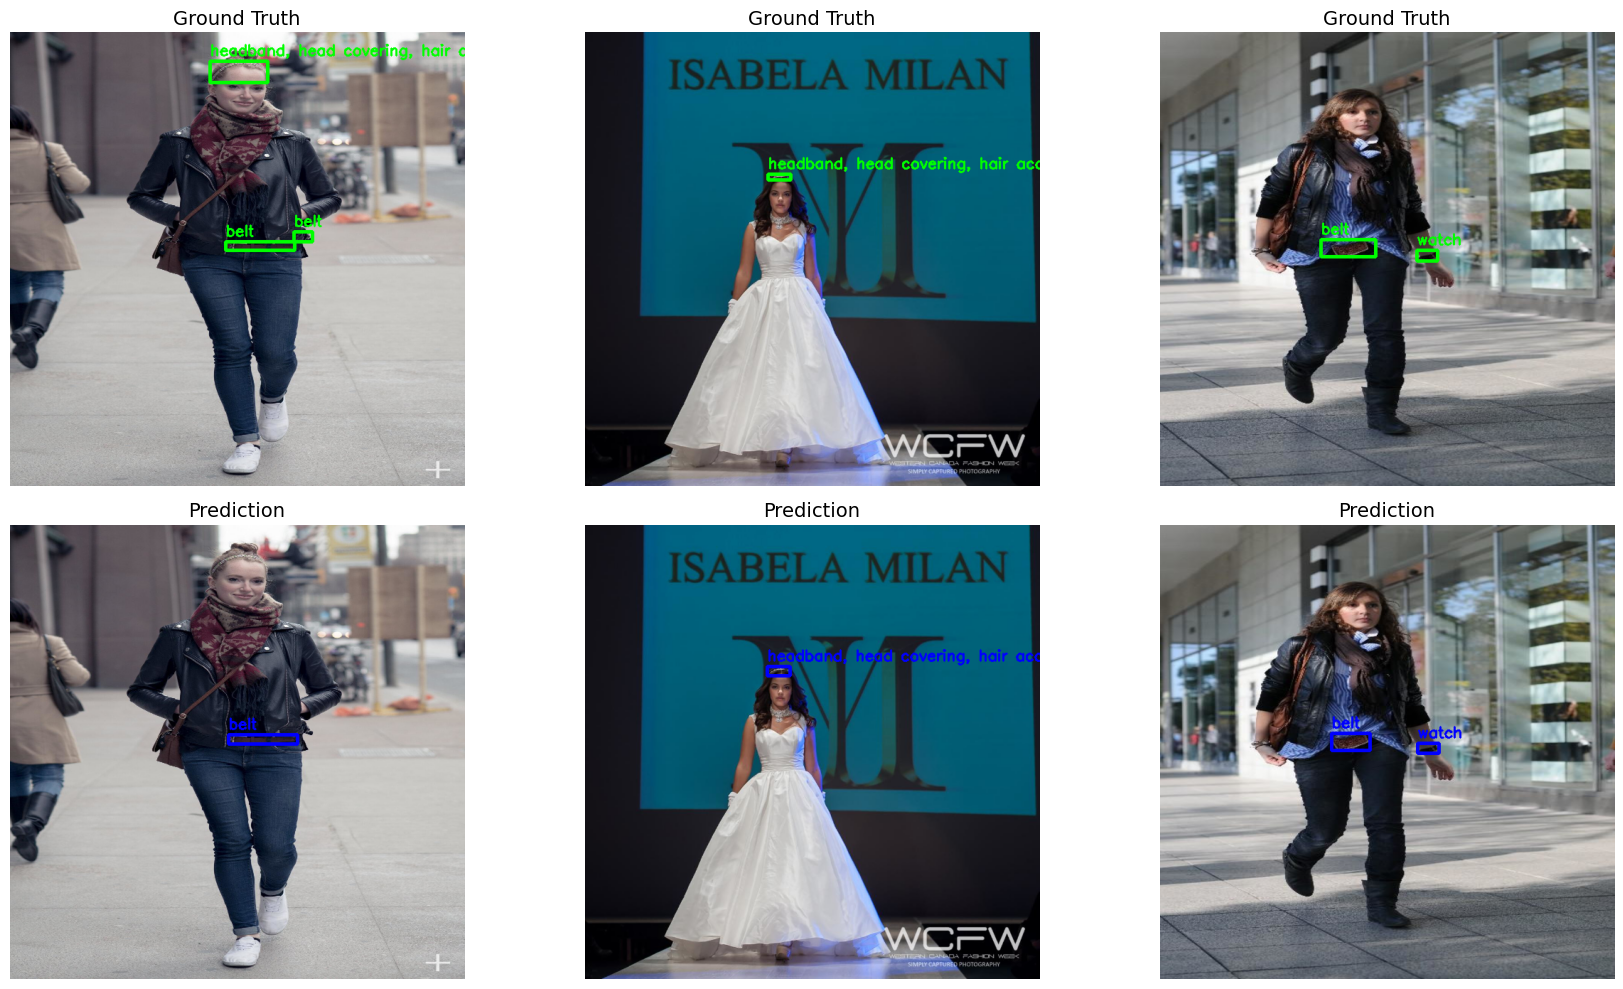

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

TARGET_SIZE = 640

for i, (img_path, gt_boxes, pred_boxes) in enumerate(selected):
    col = i % 3

    # ===== Load original image =====
    img_orig = cv2.imread(img_path)
    h0, w0, _ = img_orig.shape

    # ===== Resize image =====
    img = cv2.resize(img_orig, (TARGET_SIZE, TARGET_SIZE))
    sx = TARGET_SIZE / w0
    sy = TARGET_SIZE / h0

    # ===== GT =====
    gt_img = img.copy()
    gt_xyxy = []

    for gt in gt_boxes:
        box = yolo_to_xyxy(gt, w0, h0)   # theo ảnh gốc
        box = scale_xyxy(box, sx, sy)    # scale sang ảnh resize
        gt_xyxy.append(box)

    draw_boxes(gt_img, gt_xyxy, (0, 255, 0), class_names)

    axes[0, col].imshow(cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB))
    axes[0, col].set_title("Ground Truth", fontsize=14)
    axes[0, col].axis("off")

    # ===== PRED =====
    pred_img = img.copy()
    pred_scaled = []

    for box in pred_boxes:
        pred_scaled.append(scale_xyxy(box, sx, sy))

    draw_boxes(pred_img, pred_scaled, (255, 0, 0), class_names)

    axes[1, col].imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
    axes[1, col].set_title("Prediction", fontsize=14)
    axes[1, col].axis("off")

plt.tight_layout()
plt.show()


# 📌 Kết luận phân tích các trường hợp mô hình YOLO dự đoán sai

## 1. Chất lượng nhãn (Ground Truth) chưa chính xác
Một số nhãn gốc được annotate chưa bọc sát vật thể, bounding box còn lỏng hoặc lệch so với biên thực tế của đối tượng.  
Điều này gây nhiễu trong quá trình huấn luyện, khiến mô hình học được các đặc trưng không ổn định và ảnh hưởng trực tiếp đến độ chính xác của dự đoán.

---

## 2. Thiếu nhãn đối với các vật thể nhỏ
Trong tập dữ liệu, một số vật thể có kích thước nhỏ (đặc biệt là các phụ kiện như *watch*, *belt*) không được annotate đầy đủ.  
Việc thiếu nhãn khiến mô hình không được học đầy đủ phân bố của các vật thể nhỏ, dẫn đến hiện tượng bỏ sót (**miss detection**) trong quá trình inference.

---

## 3. Đặc thù vật thể nhỏ và độ tương phản thấp với nền
Phần lớn các vật thể nhỏ có các đặc điểm sau:
- Kích thước rất nhỏ so với toàn ảnh  
- Màu sắc gần giống với nền xung quanh  
- Ít đặc trưng hình dạng rõ ràng  

Ngay cả khi quan sát bằng mắt thường, một số trường hợp rất khó nhận biết đối tượng là gì. Do đó, mô hình gặp khó khăn trong việc trích xuất đặc trưng phân biệt, dẫn đến tỷ lệ bỏ sót cao đối với nhóm vật thể này.

---

## 4. Sự chênh lệch phân bố giữa các lớp (Class Imbalance)
Phân tích phân bố dữ liệu cho thấy sự chênh lệch rất lớn giữa các lớp trong tập dữ liệu.  
Một số lớp phổ biến có số lượng mẫu rất lớn, trong khi nhiều lớp khác chỉ có rất ít instance.

### 🔹 Top 10 classes có số instance **nhiều nhất**
| Rank | Class                     | Count |
|------|---------------------------|-------|
| 1    | sleeve                    | 59448 |
| 2    | shoe                      | 46374 |
| 3    | neckline                  | 34258 |
| 4    | pocket                    | 27179 |
| 5    | dress                     | 18739 |
| 6    | top, t-shirt, sweatshirt  | 16548 |
| 7    | pants                     | 12414 |
| 8    | collar                    | 10159 |
| 9    | zipper                    | 7991  |
| 10   | jacket                    | 7833  |

### 🔹 Top 10 classes có số instance **ít nhất**
| Rank | Class        | Count |
|------|--------------|-------|
| 1    | leg warmer   | 112   |
| 2    | umbrella    | 135   |
| 3    | cape         | 152   |
| 4    | ribbon       | 274   |
| 5    | tassel       | 335   |
| 6    | bow          | 528   |
| 7    | fringe       | 588   |
| 8    | vest         | 719   |
| 9    | epaulette   | 874   |
| 10   | jumpsuit    | 922   |

Các lớp có số lượng mẫu ít thường đồng thời là các vật thể có kích thước nhỏ và khó quan sát.  
Sự mất cân bằng này khiến mô hình có xu hướng học tốt các lớp phổ biến hơn, trong khi hiệu năng trên các lớp hiếm bị hạn chế đáng kể.

---

## 🔍 Nhận xét tổng quát
Các lỗi dự đoán quan sát được **không hoàn toàn xuất phát từ kiến trúc mô hình**, mà chủ yếu liên quan đến:
- Chất lượng và độ đầy đủ của annotation  
- Hạn chế tự nhiên của bài toán phát hiện vật thể nhỏ trong môi trường nền phức tạp  
- Sự mất cân bằng nghiêm trọng trong phân bố dữ liệu giữa các lớp (**long-tail distribution**)
- Bên cạnh đó việc áp dụng SAHI lên toàn bộ bức ảnh sẽ khiến nó gây hiểu lầm nhiều class là cái nền do background bị nhiễu quá mạnh. Nên đề xuất khi sử dụng thực tế khi xài SAHI chỉ xài để lấy thêm các class nhỏ như trang sức phụ kiện mà mô hình yolo ban đầu không detect được tránh nhiễu cũng như mang lại kết quả như kỳ vọng trong thực tế.**)

---

## ✨ Hướng cải thiện dữ liệu (đề xuất)
- Cải thiện và chuẩn hóa chất lượng annotation  
- Bổ sung dữ liệu cho các lớp hiếm và vật thể nhỏ  
